In [1]:
import os 
import re 
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import urllib.request as ur
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

from konlpy.tag import Okt
from collections import Counter

import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import random
import datetime

from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import nltk 
from nltk.corpus import stopwords
import matplotlib
from IPython.display import set_matplotlib_formats
from wordcloud import WordCloud


In [2]:
# ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò
def convert_input_data(sentences):

    # BERTÏùò ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ°ú Î¨∏Ïû•ÏùÑ ÌÜ†ÌÅ∞ÏúºÎ°ú Î∂ÑÎ¶¨
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # ÏûÖÎ†• ÌÜ†ÌÅ∞Ïùò ÏµúÎåÄ ÏãúÌÄÄÏä§ Í∏∏Ïù¥
    MAX_LEN = 128

    # ÌÜ†ÌÅ∞ÏùÑ Ïà´Ïûê Ïù∏Îç±Ïä§Î°ú Î≥ÄÌôò
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # Î¨∏Ïû•ÏùÑ MAX_LEN Í∏∏Ïù¥Ïóê ÎßûÍ≤å ÏûêÎ•¥Í≥†, Î™®ÏûêÎûÄ Î∂ÄÎ∂ÑÏùÑ Ìå®Îî© 0ÏúºÎ°ú Ï±ÑÏõÄ
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨ Ï¥àÍ∏∞Ìôî
    attention_masks = []

    # Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨Î•º Ìå®Îî©Ïù¥ ÏïÑÎãàÎ©¥ 1, Ìå®Îî©Ïù¥Î©¥ 0ÏúºÎ°ú ÏÑ§Ï†ï
    # Ìå®Îî© Î∂ÄÎ∂ÑÏùÄ BERT Î™®Îç∏ÏóêÏÑú Ïñ¥ÌÖêÏÖòÏùÑ ÏàòÌñâÌïòÏßÄ ÏïäÏïÑ ÏÜçÎèÑ Ìñ•ÏÉÅ
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Îç∞Ïù¥ÌÑ∞Î•º ÌååÏù¥ÌÜ†ÏπòÏùò ÌÖêÏÑúÎ°ú Î≥ÄÌôò
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [3]:
# Î¨∏Ïû• ÌÖåÏä§Ìä∏
def test_sentences(sentences):

    # ÌèâÍ∞ÄÎ™®ÎìúÎ°ú Î≥ÄÍ≤Ω
    model.eval()

    # Î¨∏Ïû•ÏùÑ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î°ú Î≥ÄÌôò
    inputs, masks = convert_input_data(sentences)

    # Îç∞Ïù¥ÌÑ∞Î•º GPUÏóê ÎÑ£Ïùå
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    
    b_input_ids = torch.tensor(b_input_ids).to(device).long()
            
    # Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ ÏïàÌï®
    with torch.no_grad():     
        # Forward ÏàòÌñâ
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        

    # Î°úÏä§ Íµ¨Ìï®
    logits = outputs[0]

    # CPUÎ°ú Îç∞Ïù¥ÌÑ∞ Ïù¥Îèô
    logits = logits.detach().cpu().numpy()

    return logits

In [328]:
browser = webdriver.Chrome("C:/jupyter/chromedriver.exe")


# browser.get("https://www.yogiyo.co.kr/mobile/#/13338/")

browser.get("https://www.yogiyo.co.kr/mobile/#/469202/")

browser.maximize_window()
time.sleep(2)
elem = browser.find_element_by_xpath("//*[@id='content']/div[2]/div[1]/ul/li[2]/a")
elem.click()

elem = browser.find_element_by_xpath("//*[@id='review']/li[12]")

# ÌôîÎ©¥ Í∞ÄÏû• ÏïÑÎûòÎ°ú Ïä§ÌÅ¨Î°§ ÎÇ¥Î¶¨Í∏∞
browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")

interval = 2 # 2Ï¥àÏóê ÌïúÎ≤àÏî© Ïä§ÌÅ¨Î°§ ÎÇ¥Î¶º

# ÌòÑÏû¨ Î¨∏ÏÑú ÎÜíÏù¥Î•º Í∞ÄÏ†∏ÏôÄÏÑú Ï†ÄÏû•
prev_height = browser.execute_script("return document.body.scrollHeight")

# Î∞òÎ≥µ ÏàòÌñâ
while True:
    # Ïä§ÌÅ¨Î°§ÏùÑ Í∞ÄÏû• ÏïÑÎûòÎ°ú ÎÇ¥Î¶º
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    try:
        elem.click()
    except:
        pass
    
    # ÌéòÏù¥ÏßÄ Î°úÎî© ÎåÄÍ∏∞
    time.sleep(interval)


    # ÌòÑÏû¨ Î¨∏ÏÑú ÎÜíÏù¥Î•º Í∞ÄÏ†∏ÏôÄÏÑú Ï†ÄÏû•
    curr_height = browser.execute_script("return document.body.scrollHeight")
    if curr_height == prev_height:
        break

    prev_height = curr_height

print("Ïä§ÌÅ¨Î°§ ÏôÑÎ£å")

Ïä§ÌÅ¨Î°§ ÏôÑÎ£å


In [329]:
soup = bs(browser.page_source, "lxml")
# page_sourceÎ°ú Ïä§ÌÅ¨Î°§ ÎÅùÍπåÏßÄ ÎÇ¥Î†∏ÏùÑ ÎïåÏùò html Ï†ïÎ≥¥Î•º Í∞ÄÏ†∏Ïò§Í≤å Îê®

# Ï†ïÎ≥¥) ÏÜçÏÑ±ÏùÑ Î¶¨Ïä§Ìä∏Î°ú Í∞êÏã∏Ï£ºÏñ¥ Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî Î™®Îì† Îç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏ†∏Ïò¨ Ïàò ÏûàÎã§.
# reviews = soup.find_all("div", attrs={"class":["ImZGtf mpg5gc", "Vpfmgd"]})
reviews = soup.find_all("li", attrs={"class": "list-group-item star-point ng-scope"})
print(len(reviews))
total_average = 0 # Î¶¨Î∑∞ Ï†ÑÏ≤¥ ÌèâÍ∑†
taste_average = 0 # Îßõ Ï†ÑÏ≤¥ ÌèâÍ∑†
quantity_average = 0 # Ïñë Ï†ÑÏ≤¥ ÌèâÍ∑†
delivery_average = 0 # Î∞∞Îã¨ Ï†ÑÏ≤¥ ÌèâÍ∑†


comments = []

for review in reviews:
    comment = review.find("p", attrs={"class": "ng-binding", "ng-show":"review.comment"}).text
    
    comments.append(comment)

print(comments)

763
['Ï†ïÎßêÎßõÏûàÍ≤åÎ®πÏóàÏñ¥ÏöîÎã§ÏùåÏóêÎäîÏÇ¨ÏßÑÎèÑÏò¨Î¶¥Í≤åÏöî', 'ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏñ¥Ïöî. ÏÉàÏö∞Í∞Ä ÌÉ±Í∏ÄÌïòÎãà Ïã†ÏÑ†Ìï®Ïù¥ ÎäêÍª¥ÏßëÎãàÎã§^^', 'ÌÜµÌÜµÌïúÌå¨ÌîºÏûê...ÎèÑÏö∞ÎèÑÎßõÏûàÍ±∞  Í∏âÌûàÎ®πÎäêÎùº  ÏÇ¨ÏßÑÍπúÎ∞ïÏù¥ÏßÄÎßå  Î∞òÎ∞òÎ©îÎâ¥ ÎÑàÎ¨¥Ï¢ãÏïÑÏöî ÌÜ†ÌïëÎèÑ Îì¨ÎøçÏù¥Îùº  Ï¢ãÏïÑÏöî^^', 'Îß§Î≤à Î®πÎäîÍ≥≥Ïù¥ÏßÄÎßå\nÎÑàÎ¨¥ÎßõÏûàÍ≤åÎ®πÎã§Î≥¥Îãà Ïò§ÏûêÎßàÏûê ÏÇ¨ÏßÑÏ∞çÎäîÍ±∏ ÍπåÎ®πÏóàÏñ¥Ïöî„Öé„Öé\nÏßÑÏßú Ïù¥Ïßë ÌîºÏûêÎäî Íµ≥ÏûÖÎãàÎã§', 'ÎÑàÎ¨¥ ÎßõÏûàÏóàÏñ¥Ïöî', 'ÎÑàÎ¨¥ ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏñ¥Ïöî!!', 'Ïó≠Ïãú ÌîºÏûêÏï∞ÏÜåÎßà Î≥ÑÏ†êÏóêÎäî Ïù¥Ïú†Í∞Ä ÏûàÎäîÎ≤ï\nÏ°¥ÎßõÌÉ±„Öé', 'Î∞∞Îã¨ Îπ®ÎùºÏÑú Îî∞ÎúªÌïòÍ≥† Ï¢ãÎÑ§Ïöî', 'ÌîºÏûêÍ∞Ä ÌïúÏ™ΩÏúºÎ°ú Ïè†Î†§ÏôîÏñ¥Ïöî.... ÌïòÏßÄÎßå ÎßõÏûàÏñ¥ÏÑú Î®πÏóàÏäµÎãàÎã§ „Öã„Öã', 'ÎßõÏûàÏóàÍ≥† ÌéòÌéòÎ°úÎãàÎäîÏ≤òÏùåÏù∏ÎåÄ Ï†ÑÏΩ§ÎπÑÍ∞ÄÎçîÎßõÏûàÎäîÎìØ', 'Ìï≠ÏÉÅ ÏãúÏºúÎ®πÎäî ÌîºÏûêÏßëÏù¥ÏßÄÎßå\nÎ∞∞Îã¨ÎèÑ Îπ†Î•¥Í≥† ÎÑàÎ¨¥ ÎßõÏûàÎÑ§Ïöî ^^ ÎÑàÎ¨¥ÎÑàÎ¨¥ Ï¢ãÏïÑÏöî‚ò∫Ô∏èüòç', 'ÎßõÎÇòÍ≤å ÏûòÎ®πÏóàÏäµÎãàÎã§~~~', 'ÎßõÏûáÍ≤å Î®πÏóàÏäµÎãàÎã§.\nÏπúÏ†àÌïòÍ≤å ÏïàÎÇ¥Ìï¥

In [330]:
len(comments)

763

In [331]:
comments[0]

'Ï†ïÎßêÎßõÏûàÍ≤åÎ®πÏóàÏñ¥ÏöîÎã§ÏùåÏóêÎäîÏÇ¨ÏßÑÎèÑÏò¨Î¶¥Í≤åÏöî'

In [332]:
okt = Okt() 
morphs = [] 
for sentence in comments: 
    morphs.append(okt.pos(sentence)) 
    
print(morphs)


[[('Ï†ïÎßê', 'Noun'), ('ÎßõÏûàÍ≤å', 'Adjective'), ('Î®πÏóàÏñ¥Ïöî', 'Verb'), ('Îã§Ïùå', 'Noun'), ('ÏóêÎäî', 'Josa'), ('ÏÇ¨ÏßÑ', 'Noun'), ('ÎèÑ', 'Josa'), ('Ïò¨Î¶¥Í≤åÏöî', 'Verb')], [('ÎßõÏûàÍ≤å', 'Adjective'), ('Ïûò', 'Verb'), ('Î®πÏóàÏñ¥Ïöî', 'Verb'), ('.', 'Punctuation'), ('ÏÉàÏö∞', 'Noun'), ('Í∞Ä', 'Josa'), ('ÌÉ±', 'Adverb'), ('Í∏Ä', 'Noun'), ('Ìïò', 'Suffix'), ('Îãà', 'Josa'), ('Ïã†ÏÑ†Ìï®Ïù¥', 'Adjective'), ('ÎäêÍª¥ÏßëÎãàÎã§', 'Verb'), ('^^', 'Punctuation')], [('ÌÜµÌÜµÌïú', 'Adjective'), ('Ìå¨', 'Noun'), ('ÌîºÏûê', 'Noun'), ('...', 'Punctuation'), ('ÎèÑÏö∞', 'Noun'), ('ÎèÑ', 'Josa'), ('ÎßõÏûàÍ±∞', 'Adjective'), ('Í∏âÌûà', 'Adjective'), ('Î®πÎäêÎùº', 'Verb'), ('ÏÇ¨ÏßÑ', 'Noun'), ('ÍπúÎ∞ï', 'Noun'), ('Ïù¥ÏßÄÎßå', 'Josa'), ('Î∞ò', 'Modifier'), ('Î∞ò', 'Modifier'), ('Î©îÎâ¥', 'Noun'), ('ÎÑàÎ¨¥', 'Adverb'), ('Ï¢ãÏïÑÏöî', 'Adjective'), ('ÌÜ†Ìïë', 'Noun'), ('ÎèÑ', 'Josa'), ('Îì¨Îøç', 'Noun'), ('Ïù¥Îùº', 'Josa'), ('Ï¢ãÏïÑÏöî', 'Adjective'), ('^^', 'Punctuation')], [('Îß§Î≤à', 'Noun'), ('Î®π

In [333]:
filter_words = ["Îã§Îßå", "ÍªÄ", "Î®πÍ∏∞", "Ï†ÑÏ≤¥", "ÌïúÏßÄ", "Ïò®", "ÏÉùÍ∞Å", "Î≥ÑÎ°ú", "Îßõ", "Î∞∞Îã¨", "ÎèÑ", "Ïï†", "Îëê", "Ïïû", "Ïö©", "Îïå", "Î¨¥Ï°∞Í±¥", "Ï¢Ä", "Íº≠", "ÏïÑÏ£º", "ÏùºÎã®", "ÏõêÎûò", "Îòê", "Í≤É", "ÎÇ¥", "ÎÇò", "Ïàò", "Í≤å", "Îßê", "ÏßÑÏßú", "Ï†úÏùº", "ÏµúÍ≥†", "Ï≤òÏùå", "Í≤É", "Ï†ïÎßê", "Ïù¥Î≤§Ìä∏", "Îß§Ïö∞", "Î≤à", "Í∑∏ÎÉ•", "Ïù¥Ïö©"]

noun_adj_adv_list=[]

for sentence in morphs : 
    for word, tag in sentence : 
        if tag in ['Noun'] and word not in filter_words: 
            noun_adj_adv_list.append(word) 
            
print(noun_adj_adv_list)

# noun_adj_adv_list=[] 

# for sentence in morphs : 
#     for word, tag in sentence : 
#         if tag in ['Noun'] and ("Íº≠" not in word) and ("Îã¥" not in word) and ("Ïù¥Î≤§Ìä∏" not in word) and ("ÏõêÎûò" not in word) and ("Ïó≠Ïãú" not in word) and ("Í≥≥" not in word) and ("Ïò§Îäò" not in word) and ("Îçî" not in word) and ("ÏßÑÏßú" not in word) and ("Îòê" not in word) and ("Îã§Ïùå" not in word) and ("Ï†úÏùº" not in word) and ("Ìï≠ÏÉÅ" not in word) and ("Ï≤òÏùå" not in word) and ("Ï¢Ä" not in word) and ("Í≤É" not in word) and ("ÎÇ¥" not in word) and ("ÎÇò" not in word)and ("Ïàò"not in word) and("Í≤å"not in word)and("Îßê"not in word): 
#             noun_adj_adv_list.append(word) 
            
# print(noun_adj_adv_list)


['Îã§Ïùå', 'ÏÇ¨ÏßÑ', 'ÏÉàÏö∞', 'Í∏Ä', 'Ìå¨', 'ÌîºÏûê', 'ÎèÑÏö∞', 'ÏÇ¨ÏßÑ', 'ÍπúÎ∞ï', 'Î©îÎâ¥', 'ÌÜ†Ìïë', 'Îì¨Îøç', 'Îß§Î≤à', 'Í≥≥', 'ÏûêÎßàÏûê', 'ÏÇ¨ÏßÑ', 'Ïù¥Ïßë', 'ÌîºÏûê', 'Ïó≠Ïãú', 'ÌîºÏûê', 'Ïï∞', 'ÏÜåÎßà', 'Ï†ê', 'Ïù¥Ïú†', 'Î≤ï', 'Ï°¥Îßõ', 'Îπ®', 'ÌîºÏûê', 'ÌïúÏ™Ω', 'ÌéòÌéòÎ°úÎãà', 'Ïù∏ÎåÄ', 'ÏΩ§ÎπÑ', 'Ìï≠ÏÉÅ', 'ÌîºÏûê', 'Ïßë', 'ÏïàÎÇ¥', 'ÌîºÏûê', 'ÏôìÎäîÎç∞', 'Ï°∞Í∏à', 'Ï∞å', 'Ï°ã', 'ÏÑúÎπÑÏä§', 'Ï£ºÏã†', 'ÏÉêÎü¨Îìú', 'Íµø', 'Ïñ¥Ïöî', 'Í∞ÄÏ°±', 'Î™®Îëê', 'ÏóáÏäµ', 'Î≤àÏ∞Ω', 'ÏòàÏÉÅ', 'ÏãúÍ∞Ñ', 'Î≥¥Í≥†', 'Î¶¨Î∑∞', 'Î≥¥Í≥†', 'Ï£ºÎ¨∏', 'ÎÅº', 'ÏãùÏÇ¨', 'ÏÜåÏàò', 'ÏÜåÏä§', 'ÏπòÏ¶à', 'Îì¨Îøç', 'ÏûàÏóá', 'ÏÉàÏö∞', 'ÏΩî', 'Î∞∞ÏÜ°', 'ÏñëÎèÑ', 'Î∂ÑÎèÑ', 'Í∏∞Î∂Ñ', 'ÏôÑÏ†Ñ', 'Ïöî', 'Í≥†Í∏∞', 'ÏãùÍ∞ê', 'Îß§Î≤à', 'ÌîºÏûê', 'Ïó¨Í∏∞', 'ÌîºÏûê', 'ÏÇ¨ÏßÑ', 'Ìè∞', 'Í∞ÄÎìù', 'Ïöî', 'Ïó≠Ïãú', 'Ïã†Í≤Ω', 'ÏÑúÎπÑÏä§', 'Ïäµ', 'ÏöîÏ¶ò', 'Ïù¥', 'ÌîºÏûê', 'ÏßÄÍ∏à', 'Î¶¨Î∑∞', 'ÏÑúÎπÑÏä§', 'Í±∞', 'Ïñë', 'ÌÄÑÎ¶¨Ìã∞', 'Í∑∏', 'Ïó†', 'ÏÜåÎßà', 'ÌîºÏûê', 'Ïù¥Î¶Ñ', 'Í∞í', 'ÏÑúÎπÑÏä§', 'Ïñ¥Ïö∞', 'Ïò§Îäò', 'ÎÇ®ÏïÑ'

In [334]:
count = Counter(noun_adj_adv_list)

In [335]:
words = dict(count.most_common())


In [336]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import nltk 
from nltk.corpus import stopwords
import matplotlib
from IPython.display import set_matplotlib_formats


In [337]:
%matplotlib inline

import matplotlib
from IPython.display import set_matplotlib_formats
matplotlib.rc('font',family = 'Malgun Gothic')
set_matplotlib_formats('retina')
matplotlib.rc('axes',unicode_minus = False)


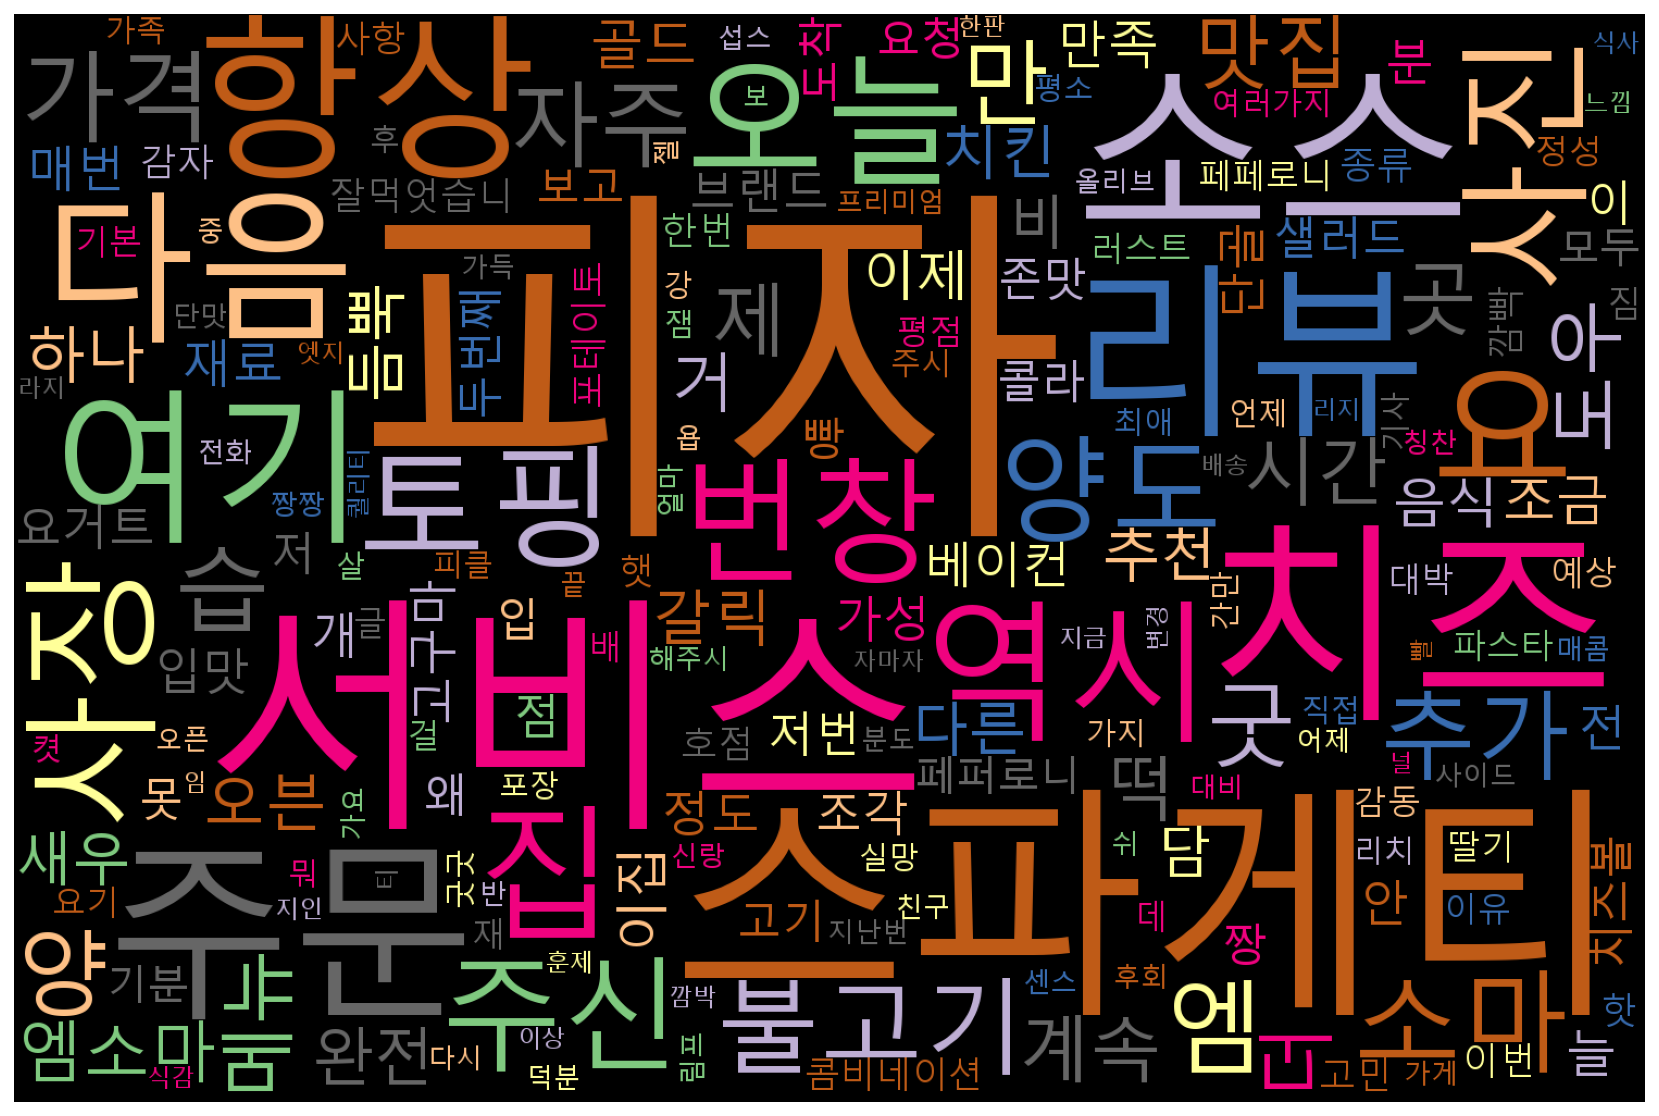

In [338]:
from wordcloud import WordCloud

wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='black',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words) 
plt.figure(figsize = (15 , 10))
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()



In [339]:
df = pd.DataFrame(comments)
df

0
0                                 Ï†ïÎßêÎßõÏûàÍ≤åÎ®πÏóàÏñ¥ÏöîÎã§ÏùåÏóêÎäîÏÇ¨ÏßÑÎèÑÏò¨Î¶¥Í≤åÏöî
1                    ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏñ¥Ïöî. ÏÉàÏö∞Í∞Ä ÌÉ±Í∏ÄÌïòÎãà Ïã†ÏÑ†Ìï®Ïù¥ ÎäêÍª¥ÏßëÎãàÎã§^^
2    ÌÜµÌÜµÌïúÌå¨ÌîºÏûê...ÎèÑÏö∞ÎèÑÎßõÏûàÍ±∞  Í∏âÌûàÎ®πÎäêÎùº  ÏÇ¨ÏßÑÍπúÎ∞ïÏù¥ÏßÄÎßå  Î∞òÎ∞òÎ©îÎâ¥ ÎÑàÎ¨¥Ï¢ãÏïÑÏöî ÌÜ†Ìïë...
3    Îß§Î≤à Î®πÎäîÍ≥≥Ïù¥ÏßÄÎßå\nÎÑàÎ¨¥ÎßõÏûàÍ≤åÎ®πÎã§Î≥¥Îãà Ïò§ÏûêÎßàÏûê ÏÇ¨ÏßÑÏ∞çÎäîÍ±∏ ÍπåÎ®πÏóàÏñ¥Ïöî„Öé„Öé\nÏßÑÏßú Ïù¥Ïßë...
4                                             ÎÑàÎ¨¥ ÎßõÏûàÏóàÏñ¥Ïöî
..                                                 ...
758  Ïò§ÌîàÌñàÎã§Í∏∏Îûò Ìò∏Í∏∞Ïã¨Î∞ò Í∏∞ÎåÄÎ∞òÏúºÎ°ú ÏãúÏºúÎ¥§Ïñ¥Ïöî~\nÎ∞∞Îã¨ÎèÑ ÏóÑÏ≤≠ Îπ†Î•¥Í≤å ÏôÄÏÑú ÌîºÏûêÏôÄ ÏÑúÎπÑ...
759                ÏπúÏ†àÌïòÍ≥† ÎßõÏù¥ ÏûàÍ≥† Í∞úÏóÖÌñáÎã§Í≥† Ïä§ÌååÍ∞úÌã∞ÎèÑ Ï±ôÍ≤® Ï£ºÏãúÍ≥† Í∞êÏÇ¨Ìï©ÎãàÎã§
760  Ìë∏ÏßêÌï¥Ïöî~~ ÌïúÏ°∞Í∞Å Î®πÏñ¥ÎèÑ Î∞∞Î∂ÄÎ•¥ÎÑ§Ïöî\nÏΩ§ÎπÑÎÑ§Ïù¥ÏÖòÌîºÏûê ÏïÑÎãåÏ§Ñ ÏïåÏïòÏñ¥Ïöî\nÌÜ†Ìïë ÏßÑÏßú ...
761  ÏßÑÏßú Î¶¨Î∑∞ Ï≤òÏùå ÎÇ®Í∏∞ÎäîÎç∞ ÏñëÎèÑ ÎßõÎèÑ ÏÑúÎπÑÏä§ÎèÑ ÏµúÍ≥†ÏûÖÎãàÎã§!! ÎçïÎ∂ÑÏóê Í∏àÏöîÏùº Î∞§ Î∞∞Î∂àÎ¶¨...
762  ÎßõÏûàÏñ¥Ïöî Ïù¥ÏÇ¨ÏôÄÏÑú ÏïÑÏßÅ ÌîºÏûê ÎßõÏßëÏùÑ Î™ªÏ∞æÏïòÎäîÎç∞ Ïó¨Í∏∞ÏÑú ÏãúÏºúÎ®πÏúºÎ†§Í≥†Ïöî ÏπòÏ¶àÍ∞Ä Îì¨Îøç Îì§...

[763 rows x 1 columns]

In [340]:
df = df.rename({0:'comment'},axis = 'columns')
df

comment
0                                 Ï†ïÎßêÎßõÏûàÍ≤åÎ®πÏóàÏñ¥ÏöîÎã§ÏùåÏóêÎäîÏÇ¨ÏßÑÎèÑÏò¨Î¶¥Í≤åÏöî
1                    ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏñ¥Ïöî. ÏÉàÏö∞Í∞Ä ÌÉ±Í∏ÄÌïòÎãà Ïã†ÏÑ†Ìï®Ïù¥ ÎäêÍª¥ÏßëÎãàÎã§^^
2    ÌÜµÌÜµÌïúÌå¨ÌîºÏûê...ÎèÑÏö∞ÎèÑÎßõÏûàÍ±∞  Í∏âÌûàÎ®πÎäêÎùº  ÏÇ¨ÏßÑÍπúÎ∞ïÏù¥ÏßÄÎßå  Î∞òÎ∞òÎ©îÎâ¥ ÎÑàÎ¨¥Ï¢ãÏïÑÏöî ÌÜ†Ìïë...
3    Îß§Î≤à Î®πÎäîÍ≥≥Ïù¥ÏßÄÎßå\nÎÑàÎ¨¥ÎßõÏûàÍ≤åÎ®πÎã§Î≥¥Îãà Ïò§ÏûêÎßàÏûê ÏÇ¨ÏßÑÏ∞çÎäîÍ±∏ ÍπåÎ®πÏóàÏñ¥Ïöî„Öé„Öé\nÏßÑÏßú Ïù¥Ïßë...
4                                             ÎÑàÎ¨¥ ÎßõÏûàÏóàÏñ¥Ïöî
..                                                 ...
758  Ïò§ÌîàÌñàÎã§Í∏∏Îûò Ìò∏Í∏∞Ïã¨Î∞ò Í∏∞ÎåÄÎ∞òÏúºÎ°ú ÏãúÏºúÎ¥§Ïñ¥Ïöî~\nÎ∞∞Îã¨ÎèÑ ÏóÑÏ≤≠ Îπ†Î•¥Í≤å ÏôÄÏÑú ÌîºÏûêÏôÄ ÏÑúÎπÑ...
759                ÏπúÏ†àÌïòÍ≥† ÎßõÏù¥ ÏûàÍ≥† Í∞úÏóÖÌñáÎã§Í≥† Ïä§ÌååÍ∞úÌã∞ÎèÑ Ï±ôÍ≤® Ï£ºÏãúÍ≥† Í∞êÏÇ¨Ìï©ÎãàÎã§
760  Ìë∏ÏßêÌï¥Ïöî~~ ÌïúÏ°∞Í∞Å Î®πÏñ¥ÎèÑ Î∞∞Î∂ÄÎ•¥ÎÑ§Ïöî\nÏΩ§ÎπÑÎÑ§Ïù¥ÏÖòÌîºÏûê ÏïÑÎãåÏ§Ñ ÏïåÏïòÏñ¥Ïöî\nÌÜ†Ìïë ÏßÑÏßú ...
761  ÏßÑÏßú Î¶¨Î∑∞ Ï≤òÏùå ÎÇ®Í∏∞ÎäîÎç∞ ÏñëÎèÑ ÎßõÎèÑ ÏÑúÎπÑÏä§ÎèÑ ÏµúÍ≥†ÏûÖÎãàÎã§!! ÎçïÎ∂ÑÏóê Í∏àÏöîÏùº Î∞§ Î∞∞Î∂àÎ¶¨...
762  ÎßõÏûàÏñ¥Ïöî Ïù¥ÏÇ¨ÏôÄÏÑú ÏïÑÏßÅ ÌîºÏûê ÎßõÏßëÏùÑ Î™ªÏ∞æÏïòÎäîÎç∞ Ïó¨Í∏∞ÏÑú ÏãúÏºúÎ®πÏúºÎ†§Í≥†Ïöî ÏπòÏ¶àÍ∞Ä Îì¨Îøç Îì§...

[763 rows x 1 columns]

In [341]:
k = 0
for i in df['comment']:
    text = re.compile('[„Ñ±-„Öé|\d\„Öè-„Ö£|Í∞Ä-Ìû£]+').findall(i)
    df.loc[k, 'comment'] = ' '.join(text).strip()
    k+=1

In [342]:
from hanspell import spell_checker

def fix_sentence(row):
    spelled_sent = spell_checker.check(row)

    fixed_sent = spelled_sent.checked
    return fixed_sent


In [343]:
df['comment'] = df['comment'].apply(fix_sentence)
df

comment
0                            Ï†ïÎßê ÎßõÏûàÍ≤å Î®πÏóàÏñ¥ ÏöîÎã§ÏùåÏóêÎäî ÏÇ¨ÏßÑÎèÑ Ïò¨Î¶¥Í≤åÏöî
1                      ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏñ¥Ïöî ÏÉàÏö∞Í∞Ä ÌÉ±Í∏Ä ÌïòÎãà Ïã†ÏÑ†Ìï®Ïù¥ ÎäêÍª¥ÏßëÎãàÎã§
2    ÌÜµÌÜµÌïú Ìå¨ ÌîºÏûê ÎèÑÏö∞ÎèÑ ÎßõÏûàÍ≤å Í∏âÌûà Î®πÎäêÎùº ÏÇ¨ÏßÑ ÍπúÎπ°Ïù¥ÏßÄÎßå Î∞òÎ∞ò Î©îÎâ¥ ÎÑàÎ¨¥ Ï¢ãÏïÑÏöî ...
3    Îß§Î≤à Î®πÎäî Í≥≥Ïù¥ÏßÄÎßå ÎÑàÎ¨¥ ÎßõÏûàÍ≤å Î®πÎã§ Î≥¥Îãà Ïò§ÏûêÎßàÏûê ÏÇ¨ÏßÑ Ï∞çÎäî Í±∏ ÍπåÎ®πÏóàÏñ¥Ïöî„Öé„Öé ÏßÑ...
4                                             ÎÑàÎ¨¥ ÎßõÏûàÏóàÏñ¥Ïöî
..                                                 ...
758  Ïò§ÌîàÌñàÎã§Í∏∏Îûò Ìò∏Í∏∞Ïã¨ Î∞ò Í∏∞ÎåÄÎ∞òÏúºÎ°ú ÏãúÏºúÎ¥§Ïñ¥Ïöî Î∞∞Îã¨ÎèÑ ÏóÑÏ≤≠ Îπ†Î•¥Í≤å ÏôÄÏÑú ÌîºÏûêÏôÄ ÏÑúÎπÑÏä§...
759                ÏπúÏ†àÌïòÍ≥† ÎßõÏù¥ ÏûàÍ≥† Í∞úÏóÖÌñàÎã§Í≥† Ïä§ÌååÍ≤åÌã∞ÎèÑ Ï±ôÍ≤® Ï£ºÏãúÍ≥† Í∞êÏÇ¨Ìï©ÎãàÎã§
760  Ìë∏ÏßêÌï¥Ïöî Ìïú Ï°∞Í∞Å Î®πÏñ¥ÎèÑ Î∞∞Î∂ÄÎ•¥ÎÑ§Ïöî ÏΩ§ÎπÑÎÑ§Ïù¥ÏÖò ÌîºÏûê ÏïÑÎãå Ï§Ñ ÏïåÏïòÏñ¥Ïöî ÌÜ†Ìïë ÏßÑÏßú Ïã§...
761  ÏßÑÏßú Î¶¨Î∑∞ Ï≤òÏùå ÎÇ®Í∏∞ÎäîÎç∞ ÏñëÎèÑ ÎßõÎèÑ ÏÑúÎπÑÏä§ÎèÑ ÏµúÍ≥†ÏûÖÎãàÎã§ ÎçïÎ∂ÑÏóê Í∏àÏöîÏùº Î∞§ Î∞∞Î∂àÎ¶¨ Ïûò...
762  ÎßõÏûàÏñ¥Ïöî Ïù¥ÏÇ¨ ÏôÄÏÑú ÏïÑÏßÅ ÌîºÏûê Îßõ ÏßëÏùÑ Î™ª Ï∞æÏïòÎäîÎç∞ Ïó¨Í∏∞ÏÑú ÏãúÏºú Î®πÏúºÎ†§Í≥†Ïöî ÏπòÏ¶àÍ∞Ä ...

[763 rows x 1 columns]

In [545]:
def tokenizer(row):
    morphs = []
    morphs.append(okt.pos(row))
    
    
    req_tokens = []

    filter_words = ['Ï¢Ä', 'Îã¥', 'Í±∞', 'Í≤É', 'Ìï†', 'Ìïò', 'Ìï¥', 'Ìïú', 'Îã§Ïùå', 'Îã¥', 'ÏßúÎ¶¨', 'Îã§Î•∏', 'ÏãúÏºú','Ïò§Îäò', 'Îß§Ïö∞'\
                   ,'Ïßê', 'Îã§Î•º', 'Ïôú', 'Ïïà', 'Í∑∏ÎûòÏöî', 'Î¨¥Ïóá', 'ÎåìÍ∏Ä', 'Ïãù', 'ÌïòÎÇò', 'ÏïΩÍ∞Ñ', 'Ïó¨Í∏∞', 'Í∏∞ÎèÑ','Îßê'\
                    ,'ÏöîÏ¶ò','ÏôÑÏ†ÑÌûà','Îïê','ÎûÄ', 'Ï†ÄÌù¨','Ïö∞Î¶¨','Ï†ú','Ï†ê','Îßà','Îïå','ÏÇºÏïÑ', 'ÌïúÎßàÎîî', 'Ïã∂ÎÑ§Ïöî', 'Ìï≠ÏÉÅ'\
                   ,'Îëò','Ï†ÑÎ∂Ä','ÎÅº','ÌïòÏãúÍ≥†','ÏûàÏóàÏñ¥Ïöî','ÏóÜÏóàÏñ¥Ïöî','ÌïòÍ≥†','ÌñàÎçò','Ï§ë','Ï†ïÎèÑ','Ïò§Í≤å','Îçî','ÏÇ¨Ïû•Îãò','Ïïû'\
                   ,'Í≤å','Ï†ïÎßê','Ïßë','Ïù¥','Í∞ôÏäµÎãàÎã§','ÏÇ¨Ïû•','Í±∏','Î≤à','Ï†Ñ','Í±¥','Î≥¥','Í∞ôÏïÑÏöî','ÏßÑÏßú','Îëê','Ï≤òÏùå','Í≥ÑÏÜç'\
                   ,'Î¶¨Î∑∞','ÏûÖ','Í∞ú','Í∞ÄÏßÄ','ÏûÖÎãàÎã§','Ï∂îÍ∞Ä','Ï£ºÎ¨∏','Î∞∞Îã¨','ÏÑúÎπÑÏä§']
#     filter_words = ['ÎÑàÎ¨¥', 'Ï¢Ä', 'Í∑ºÎç∞', 'ÏñëÎèÑ', 'Ïñ¥', 'Ï†Ñ', 'Ìùê']

    for sentence in morphs : 
        for word, tag in sentence : 
#             if (tag in ['Noun'] or tag in ['Verb'] or tag in ['Adjective']) and word not in filter_words: 
            if (tag in ['Noun'] or tag in ['Adjective']) and word not in filter_words: 
                req_tokens.append(word) 
    
#     return morphs
    return req_tokens

tokenizer('Ïò§ÎûúÎßåÏóê ÏãúÏº∞ÎäîÎç∞ ÎßõÏù¥ ÏòàÏ†Ñ Í∞ôÏßÄ ÏïäÎÑ§Ïöî. ÎπÑÏã∏Ïöî. ÌôçÌï©ÏùÄ Íµ≠Î¨ºÏù¥ ÏôÑÏ†ÑÌûà ÏÉàÏÑú ÏôîÏñ¥Ïöî „Öú')

['Îßå', 'Îßõ', 'ÏòàÏ†Ñ', 'Í∞ôÏßÄ', 'ÎπÑÏã∏Ïöî', 'ÌôçÌï©', 'Íµ≠Î¨º']

In [546]:
df['com_tokens'] = df['comment'].apply(tokenizer)
df

comment  \
0                            Ï†ïÎßê ÎßõÏûàÍ≤å Î®πÏóàÏñ¥ ÏöîÎã§ÏùåÏóêÎäî ÏÇ¨ÏßÑÎèÑ Ïò¨Î¶¥Í≤åÏöî   
1                      ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏñ¥Ïöî ÏÉàÏö∞Í∞Ä ÌÉ±Í∏Ä ÌïòÎãà Ïã†ÏÑ†Ìï®Ïù¥ ÎäêÍª¥ÏßëÎãàÎã§   
2    ÌÜµÌÜµÌïú Ìå¨ ÌîºÏûê ÎèÑÏö∞ÎèÑ ÎßõÏûàÍ≤å Í∏âÌûà Î®πÎäêÎùº ÏÇ¨ÏßÑ ÍπúÎπ°Ïù¥ÏßÄÎßå Î∞òÎ∞ò Î©îÎâ¥ ÎÑàÎ¨¥ Ï¢ãÏïÑÏöî ...   
3    Îß§Î≤à Î®πÎäî Í≥≥Ïù¥ÏßÄÎßå ÎÑàÎ¨¥ ÎßõÏûàÍ≤å Î®πÎã§ Î≥¥Îãà Ïò§ÏûêÎßàÏûê ÏÇ¨ÏßÑ Ï∞çÎäî Í±∏ ÍπåÎ®πÏóàÏñ¥Ïöî„Öé„Öé ÏßÑ...   
4                                             ÎÑàÎ¨¥ ÎßõÏûàÏóàÏñ¥Ïöî   
..                                                 ...   
758  Ïò§ÌîàÌñàÎã§Í∏∏Îûò Ìò∏Í∏∞Ïã¨ Î∞ò Í∏∞ÎåÄÎ∞òÏúºÎ°ú ÏãúÏºúÎ¥§Ïñ¥Ïöî Î∞∞Îã¨ÎèÑ ÏóÑÏ≤≠ Îπ†Î•¥Í≤å ÏôÄÏÑú ÌîºÏûêÏôÄ ÏÑúÎπÑÏä§...   
759                ÏπúÏ†àÌïòÍ≥† ÎßõÏù¥ ÏûàÍ≥† Í∞úÏóÖÌñàÎã§Í≥† Ïä§ÌååÍ≤åÌã∞ÎèÑ Ï±ôÍ≤® Ï£ºÏãúÍ≥† Í∞êÏÇ¨Ìï©ÎãàÎã§   
760  Ìë∏ÏßêÌï¥Ïöî Ìïú Ï°∞Í∞Å Î®πÏñ¥ÎèÑ Î∞∞Î∂ÄÎ•¥ÎÑ§Ïöî ÏΩ§ÎπÑÎÑ§Ïù¥ÏÖò ÌîºÏûê ÏïÑÎãå Ï§Ñ ÏïåÏïòÏñ¥Ïöî ÌÜ†Ìïë ÏßÑÏßú Ïã§...   
761  ÏßÑÏßú Î¶¨Î∑∞ Ï≤òÏùå ÎÇ®Í∏∞ÎäîÎç∞ ÏñëÎèÑ ÎßõÎèÑ ÏÑúÎπÑÏä§ÎèÑ ÏµúÍ≥†ÏûÖÎãàÎã§ ÎçïÎ∂ÑÏóê Í∏àÏöîÏùº Î∞§ Î∞∞Î∂àÎ¶¨ Ïûò...   
762  ÎßõÏûàÏñ¥Ïöî Ïù¥ÏÇ¨ ÏôÄÏÑú ÏïÑÏßÅ ÌîºÏûê Îßõ ÏßëÏùÑ Î™ª Ï∞æÏïòÎäîÎç∞ Ïó¨Í∏∞ÏÑú ÏãúÏºú Î®πÏúºÎ†§Í≥†Ïöî ÏπòÏ¶àÍ∞Ä ...   

                                            com_tokens  
0                                       [ÎßõÏûàÍ≤å, ÏöîÎã§Ïùå, ÏÇ¨ÏßÑ]  
1                               [ÎßõÏûàÍ≤å, ÏÉàÏö∞, Í∏Ä, ÌïòÎãà, Ïã†ÏÑ†Ìï®Ïù¥]  
2    [ÌÜµÌÜµÌïú, Ìå¨, ÌîºÏûê, ÎèÑÏö∞, ÎßõÏûàÍ≤å, Í∏âÌûà, ÏÇ¨ÏßÑ, ÍπúÎπ°, Î∞ò, Î©îÎâ¥, Ï¢ãÏïÑÏöî, ...  
3                     [Îß§Î≤à, Í≥≥, ÎßõÏûàÍ≤å, ÏûêÎßàÏûê, ÏÇ¨ÏßÑ, Ïù¥Ïßë, ÌîºÏûê, Íµ≥]  
4                                              [ÎßõÏûàÏóàÏñ¥Ïöî]  
..                                                 ...  
758  [Ïò§Ìîà, Ìò∏Í∏∞Ïã¨, Î∞ò, ÎåÄÎ∞ò, Îπ†Î•¥Í≤å, ÌîºÏûê, Ï£ºÏã†, Ïä§ÌååÍ≤åÌã∞, Îî∞ÎúªÌñàÏñ¥Ïöî, ÎßõÏûàÍ≤å...  
759                        [ÏπúÏ†àÌïòÍ≥†, Îßõ, ÏûàÍ≥†, Í∞úÏóÖ, Ïä§ÌååÍ≤åÌã∞, Ï£ºÏãú]  
760        [ÏßêÌï¥, Ï°∞Í∞Å, Î∞∞Î∂ÄÎ•¥ÎÑ§Ïöî, ÏΩ§ÎπÑÎÑ§Ïù¥ÏÖò, ÌîºÏûê, ÏïÑÎãå, Ï§Ñ, ÌÜ†Ìïë, Ïã§ÌïòÎÑ§Ïöî]  
761                     [ÏñëÎèÑ, Îßõ, ÏµúÍ≥†, ÎçïÎ∂Ñ, Í∏àÏöîÏùº, Î∞§, Î∞∞, Î∂àÎ¶¨]  
762  [ÎßõÏûàÏñ¥Ïöî, Ïù¥ÏÇ¨, ÌîºÏûê, Îßõ, Î™ª, ÏπòÏ¶à, Îì¨Îøç, ÎßõÏûàÎÑ§Ïöî, ÏΩòÏï§ÏΩò, ÌïòÏôÄ, Ïù¥Ïïà...  

[763 rows x 2 columns]

In [547]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = df['com_tokens'], size = 100, window = 5, min_count = 0, workers = 4, sg = 1)

In [548]:
model.wv.vectors.shape

(1355, 100)

In [549]:
model_result = model.wv.most_similar('ÌîºÏûê')
print(model_result)

[('Îßõ', 0.9994710683822632), ('ÏÜåÏä§', 0.9993500709533691), ('ÎßõÏûàÏñ¥Ïöî', 0.9992629885673523), ('Ïä§ÌååÍ≤åÌã∞', 0.9991964101791382), ('ÏπòÏ¶à', 0.9991903305053711), ('Î∂àÍ≥†Í∏∞', 0.9991313815116882), ('ÎßõÏûàÍ≥†', 0.9990414977073669), ('Ï¢ãÍ≥†', 0.99901282787323), ('ÌÜ†Ìïë', 0.9989806413650513), ('Î≤àÏ∞Ω', 0.9989179372787476)]


In [550]:
model_result = model.wv.most_similar('Ïä§ÌååÍ≤åÌã∞')
print(model_result)

[('ÌîºÏûê', 0.9991965293884277), ('Îßõ', 0.9991743564605713), ('ÏÜåÏä§', 0.9990441799163818), ('ÌÜ†Ìïë', 0.9988800883293152), ('Î∂àÍ≥†Í∏∞', 0.9988703727722168), ('ÎßõÏûàÏñ¥Ïöî', 0.9987902641296387), ('ÏπòÌÇ®', 0.9987826347351074), ('ÏπòÏ¶à', 0.9987446069717407), ('Î©îÎâ¥', 0.9986929893493652), ('ÎßõÏûàÍ≥†', 0.9985755681991577)]


In [551]:
model_result = model.wv.most_similar('Îßõ')
print(model_result)

[('ÌîºÏûê', 0.9994711875915527), ('Ïä§ÌååÍ≤åÌã∞', 0.9991744160652161), ('Î∂àÍ≥†Í∏∞', 0.999101996421814), ('ÏπòÏ¶à', 0.9990530014038086), ('ÎßõÏûàÏñ¥Ïöî', 0.9990182518959045), ('ÏÜåÏä§', 0.9989992380142212), ('ÌÜ†Ìïë', 0.9989762902259827), ('Îòê', 0.9989641904830933), ('ÏÇ¨ÏßÑ', 0.9989042282104492), ('ÏπòÌÇ®', 0.9987931847572327)]


In [552]:
model_result = model.wv.most_similar('Í∞ÄÍ≤©')
print(model_result)

[('ÌîºÏûê', 0.9988082051277161), ('ÌÜ†Ìïë', 0.9987693428993225), ('Îßõ', 0.9985722303390503), ('ÏπòÏ¶à', 0.9985359907150269), ('ÎßõÏûàÏñ¥Ïöî', 0.9984790086746216), ('ÎßõÏûàÍ≥†', 0.9982807636260986), ('Ïä§ÌååÍ≤åÌã∞', 0.9982725381851196), ('Î©îÎâ¥', 0.9982336163520813), ('ÏπòÌÇ®', 0.998218834400177), ('Î≤àÏ∞Ω', 0.9982142448425293)]


In [553]:
model_result = model.wv.most_similar('ÏãùÍ∞ê')
print(model_result)

[('Ïò§Î∏ê', 0.9734054803848267), ('ÏπòÏ¶à', 0.9733552932739258), ('Ï¢ãÏïòÏñ¥Ïöî', 0.9732925891876221), ('Í≥®Îìú', 0.9729015827178955), ('Îã®Îßõ', 0.9728123545646667), ('ÌîºÏûê', 0.9725822806358337), ('ÏÇ¨ÏßÑ', 0.9725468158721924), ('ÎßõÏûàÎÑ§Ïöî', 0.9725426435470581), ('Îì¨Îøç', 0.9725161194801331), ('ÎßõÏûàÍ≤å', 0.9724258184432983)]


In [554]:
model_result = model.wv.most_similar('ÏπòÏ¶à')
print(model_result)

[('ÌîºÏûê', 0.9991903305053711), ('ÎßõÏûàÏñ¥Ïöî', 0.9991334676742554), ('Îßõ', 0.9990529417991638), ('ÎßõÏûàÍ≤å', 0.9989532232284546), ('ÏÜåÏä§', 0.9989513158798218), ('Î∂àÍ≥†Í∏∞', 0.9987955689430237), ('Ïä§ÌååÍ≤åÌã∞', 0.9987446069717407), ('ÏÇ¨ÏßÑ', 0.9987075328826904), ('Îòê', 0.9986909627914429), ('Í≥≥', 0.9986403584480286)]


In [555]:
model_result = model.wv.most_similar('ÏÜåÏä§')
print(model_result)

[('ÌîºÏûê', 0.9993501901626587), ('Ïä§ÌååÍ≤åÌã∞', 0.9990441799163818), ('Îßõ', 0.9989992380142212), ('ÏπòÏ¶à', 0.9989513158798218), ('ÎßõÏûàÏñ¥Ïöî', 0.9988291263580322), ('ÌÜ†Ìïë', 0.9987046718597412), ('Î∂àÍ≥†Í∏∞', 0.9987013339996338), ('Ï¢ãÏùÄ', 0.9986317753791809), ('ÏπòÌÇ®', 0.9985085725784302), ('ÎßõÏûàÍ≥†', 0.9984883069992065)]


In [15]:
def Sentiment_Analysis(list):
        # ÎîîÎ∞îÏù¥Ïä§ ÏÑ§Ï†ï
    global device
    if torch.cuda.is_available():    
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')
    global model    
    model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
    model.cuda()

    PATH = './'
    model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))

    global tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
    positive = []
    negative = []
    
    for i in list:
        logits = test_sentences([i])
        if np.argmax(logits) == 1:
            positive.append(i)
        elif np.argmax(logits) == 0:
            negative.append(i)
    return positive, negative    

In [16]:
positive_comments, negative_comments = Sentiment_Analysis(comments)

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [17]:
positive_comments

['Î∑îÌéòÍ∞ÄÎ©¥ Î®πÏùÑ Ïàò ÏûàÎäî Ï°±Î∞ú ÎßõÏûÖÎãàÎã§ ÌïòÏßÄÎßå Ï°±Î∞ú ÎπºÍ≥†Îäî Îã§ ÎßõÏûàÏóàÏäµÎãàÎã§',
 'Ï§ëÏßúÎ¶¨ 3Î™ÖÏù¥ Î®∏Íº¨ÎèÑ ÎÇ®ÏïòÏñ¥Ïöî...Í∞ÄÍ≤©ÎèÑ Ï∞©ÌïòÍµ¨ ÎßõÎèÑ Ï†ïÍ∞à ÍπîÎÅîÌïòÎÑ§Ïöî...Î≥¥ÏåàÍ≥†Í∏∞ÎèÑ ÌçΩÌçΩÌïòÍ±∞ÎÇò ÎπÑÍ≥ÑÍ∞Ä ÎßåÏª§ÎÇò ÌïòÏßÄÏïäÍµ¨ ÎπÑÏú®Ïù¥ Îî± Ï°∞ÏúºÎÑ§Ïöî..Î≥¥ÏåàÌïòÎ©¥ ÏÉùÍ∞ÅÎÇ†Í∫º Í∞ôÏïÑÏöî',
 'ÎßõÏûàÍ≤å ÏûòÎ®πÏóàÏäµÎãàÎã§',
 'ÎßõÏûàÍ≤å Ïûò Î®πÏóàÏäµÎãàÎã§',
 'ÎßõÏûàÏñ¥Ïöî~~~~~~',
 'Î∞∞Îã¨Ïù¥ÎÑòÎä£ÎÑ§Ïó¨Ï†ÄÏãúÍ∞ìÏï†ÏïàÏò§Í≥†',
 'ÏÉàÏö∞Ï†ì Ï£ºÏã¨ Ï°∞ÏùÑÌÖêÎåÄ',
 'ÎÉÑÏÉà ÏïàÎÇòÏöî ÏñëÎèÑ Í¥úÏ∞ÆÏïÑÏöî',
 'ÎßõÏùÄÍ¥úÏ∞¨ÏùÄÎç∞ ÏÉÅÏ∂îÍ∞Ä ÏûòÏïàÏîªÏñ¥Ï†îÎÑ§Ïöî',
 'ÏüÅÎ∞òÍµ≠ÏàòÍ∞Ä ÎßõÏûàÏñ¥ÏÑú Ìï≠ÏÉÅ Ïó¨Í∏∞ÏÑú Ï£ºÎ¨∏Ìï¥Ïöî\nÎ≥¥ÏåàÎèÑ Ï°±Î∞úÎèÑ Ìï≠ÏÉÅ ÎßõÏûàÎäîÎç∞ Ïù¥Î≤à Î≥¥ÏåàÏùÄ Ï¢Ä ÌçΩÌçΩÌïúÏãùÍ∞êÏù¥ÎùºÏÑú ÏïÑÏâ¨Ïõ†ÏäµÎãàÎã§',
 'Î∞∞Îã¨ÏùÄ Ï¢Ä Îä¶ÏóàÏßÄÎßå ÎßõÏùÄ ÏûàÏóàÏñ¥Ïöî.',
 'Ï†ïÎßêÎßõÏûàÏäµÎãàÎã§!  Î™ÖÌíàÏû•Ï∂©ÎèôÏô∏ÏóêÎäî ÏïàÏãúÏºúÎ®πÏñ¥Ïöî',
 'ÎßõÏûàÍ≥† Î∞∞Îã¨ÌïòÏãúÎäîÎ∂ÑÎèÑ ÏóÑÏ≤≠ ÏπúÏ†àÌïòÏãúÍ≥†!!!',
 'ÎßõÏûàÏñ¥Ïöî ÎßõÏûàÏñ¥Ïöî',
 'Ï≤òÏùåÎ®πÎäîÎ

In [18]:
negative_comments

['Ïò§ÎûúÎßåÏóê ÏãúÏº∞ÎäîÎç∞ ÎßõÏù¥ ÏòàÏ†ÑÍ∞ôÏ∞å ÏïäÎÑ§Ïöî~\nÌôçÌï©ÏùÄ Íµ≠Î¨ºÏù¥ Îã§ ÏÉàÏÑú ÏôîÏñ¥Ïöî~„Öú',
 'Ïó¨ÌÉúÍπåÏßÄ Î®πÎçòÏ§ëÏµúÍ≥†Î°ú ÎßõÏóÜÏñ¥ Îã§ \nÎ≤ÑÎ†§Î≤ÑÎ†∑Ïñ¥Ïöî',
 'ÏûòÎ®πÏñ¥ÏÑúÏöî ÌòºÏûêÎ®πÍ∏∞ Î™®ÏûòÎùºÏßÄÎèÑÏïäÏïÑÏÑúÏöî',
 'Î∞∞Îã¨Ïù¥ Îä¶Í≤åÏôìÏßÄÎßå ÎßõÏùÄ Ï°∞ÏïóÏñ¥Ïöî.ÎßâÍµ≠Ïàò ÏñëÎÖêÏùÄ ÎßõÏûáÎäîÎç∞ Î©¥ÏóêÏÑú ÎÉÑÏÉàÍ∞ÄÏ¢ÄÎÇòÎÑ§Ïöî',
 'ÏôÄ „Ö†„Ö†  Ïù¥Í∞ÄÍ≤©Ïù¥ Ïù¥Íµ¨ÏÑ±Ïù¥!??!??',
 'ÏùåÏãùÎßõÍ≥º ÏñëÏùÄ ÎßåÏ°±ÌïòÏòÄÏúºÎÇò Î∞∞Îã¨ÏõêÏùò ÏÑúÎπÑÏä§Ï∞©Ïò§Î°ú Ï¢Ä ÏïÑÏâ¨Ïö¥Ï†êÏùÄ ÏûàÏóàÏäµÎãàÎã§',
 'Ïùå..ÏïΩÍ∞ÑÎßõÏù¥Î∞çÎ∞çÌñàÏñ¥Ïöî',
 'Î≥¥ÏåàÏùÄ ÍπÄÏπòÎßõÏúºÎ°ú Î®πÎäîÎç∞\nÍπÄÏπòÍ∞Ä Îçú ÎßõÏûàÏóàÏñ¥Ïöî\nÎ∞∞Îã¨ÏùÄ 35Î∂Ñ Í±∏Î†§Ïñ¥Ïöî',
 'ÎÑàÎ¨¥ ÎßõÏóÜÏñ¥Ïöî... ÏòàÏ†ÑÏù¥Îûë ÎßõÏù¥Ï¢Ä Îã§Î•∏ÎìØ....',
 'Î¶¨Î∑∞Î≥¥Í≥† Ï≤òÏùåÏãúÏº∞ÎäîÎç∞ ÎßõÎÇòÎÑ§Ïöî~\nÎã§ÏùåÏóêÎèÑ Ïó¨Í∏∞ÏóêÏÑú ÏãúÌÇ¨Í∫ºÍ∞ôÏïÑÏöî^^',
 'Ï°±Î∞úÏóêÏÑú ÎÉÑÏÉàÍ∞Ä ÎÇòÏöî... Ïö∞Ïö∏Ìï¥ÏÑú Í∏∞Î∂ÑÌíÄÎ†§Í≥† Ï£ºÎ¨∏ÌñàÎäîÎç∞ Îçî Ïö∞Ïö∏ÌïòÎÑ§Ïöî....',
 'ÎßõÏùÄ Ï¢ãÏïòÍµ¨Ïöî^^ ÏñëÏùÑ Ï¢ÄÎçî ÎäòÎ†§Ï£ºÏãúÎ©¥ Ï¢ãÏùÑÍ≤É Í∞ôÏäµÎãàÎã§',
 '

In [19]:
def make_wordcloud(list):
    okt = Okt() 
    morphs = [] 
    for sentence in list: 
        morphs.append(okt.pos(sentence))

    
    filter_words = ["Îã§Îßå", "ÍªÄ", "Î®πÍ∏∞", "Ï†ÑÏ≤¥", "ÌïúÏßÄ", "Ïò®", "ÏÉùÍ∞Å", "Î≥ÑÎ°ú", "Îßõ", "Î∞∞Îã¨", "ÎèÑ", "Ïï†", "Îëê", "Ïïû", "Ïö©", "Îïå", "Î¨¥Ï°∞Í±¥", "Ï¢Ä", "Íº≠", "ÏïÑÏ£º", "ÏùºÎã®", "ÏõêÎûò", "Îòê", "Í≤É", "ÎÇ¥", "ÎÇò", "Ïàò", "Í≤å", "Îßê", "ÏßÑÏßú", "Ï†úÏùº", "ÏµúÍ≥†", "Ï≤òÏùå", "Í≤É", "Ï†ïÎßê", "Ïù¥Î≤§Ìä∏", "Îß§Ïö∞", "Î≤à", "Í∑∏ÎÉ•", "Ïù¥Ïö©"]
    noun_adj_adv_list=[]

    for sentence in morphs : 
        for word, tag in sentence : 
            if tag in ['Noun'] and word not in filter_words: 
                noun_adj_adv_list.append(word) 
                
    count = Counter(noun_adj_adv_list)
    words = dict(count.most_common())
    
    matplotlib.rc('font',family = 'Malgun Gothic')
    set_matplotlib_formats('retina')
    matplotlib.rc('axes',unicode_minus = False)
    
    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words) 
    plt.imshow(wordcloud) 
    plt.axis('off') 
    return plt.show()

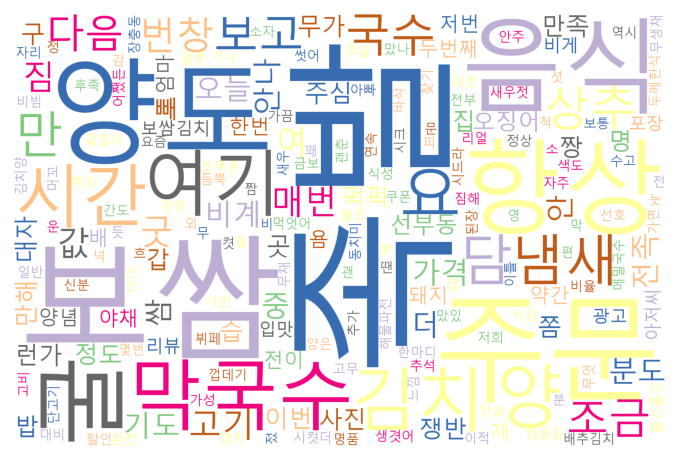

In [20]:
make_wordcloud(positive_comments)

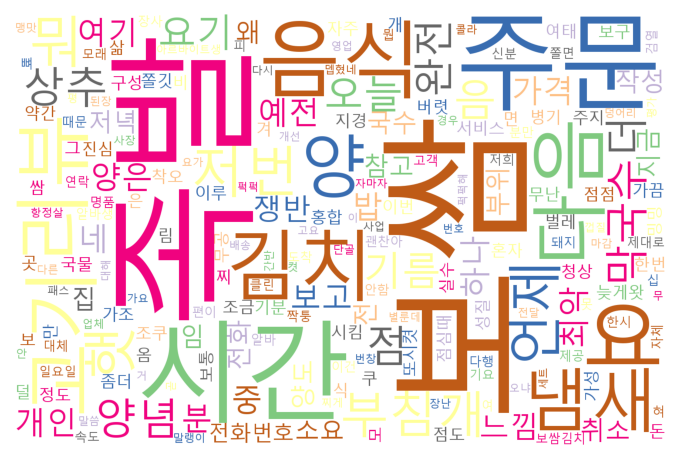

In [21]:
make_wordcloud(negative_comments)

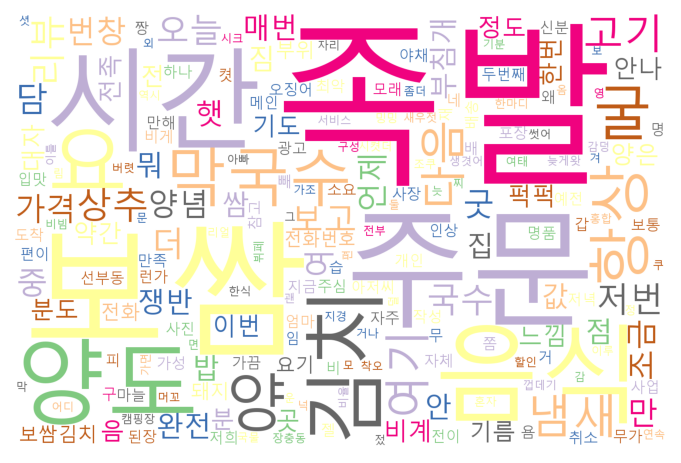

In [22]:
make_wordcloud(comments)

In [213]:
twitter.add_dictionary('ÏùÄÍ≤ΩÏù¥', 'Noun')

In [214]:
okt.morphs('ÏùÄÍ≤ΩÏù¥Îäî ÏÇ¨Î¨¥Ïã§Î°ú Í∞îÏäµÎãàÎã§.')

['ÏùÄÍ≤Ω', 'Ïù¥', 'Îäî', 'ÏÇ¨Î¨¥Ïã§', 'Î°ú', 'Í∞îÏäµÎãàÎã§', '.']

In [192]:
from hanspell import spell_checker

sent = "Îã¥Ïóê Îòê ÏãúÏºúÎ®πÏùÑÍ≤åÏöî"
spelled_sent = spell_checker.check(sent)

hanspell_sent = spelled_sent.checked
print(hanspell_sent)

Îã¥Ïóê Îòê ÏãúÏºú Î®πÏùÑÍ≤åÏöî


In [209]:
sent = 'Ïò§ÎûúÎßåÏóê ÏãúÏº∞ÎäîÎç∞ Îπ®Î¶¨ ÎßõÏù¥ ÏòàÏ†Ñ Í∞ôÏßÄ ÏïäÎÑ§Ïöî ÌôçÌï©ÏùÄ Íµ≠Î¨ºÏù¥ Îã§ ÏÉàÏÑú ÏôîÏñ¥Ïöî „Öú'

In [143]:
sent = 'Ïßê,Îã§Î•º,ÏÇºÏïÑ,ÏïΩÍ∞Ñ,ÏôÑÏ†ÑÌûà'

In [210]:
from konlpy.tag import Okt  
okt=Okt()  
print(okt.morphs(sent))

['Ïò§Îûú', 'Îßå', 'Ïóê', 'ÏãúÏº∞ÎäîÎç∞', 'Îπ®Î¶¨', 'Îßõ', 'Ïù¥', 'ÏòàÏ†Ñ', 'Í∞ôÏßÄ', 'ÏïäÎÑ§Ïöî', 'ÌôçÌï©', 'ÏùÄ', 'Íµ≠Î¨º', 'Ïù¥', 'Îã§', 'ÏÉàÏÑú', 'ÏôîÏñ¥Ïöî', '„Öú']


In [144]:
print(okt.pos(sent)) 

[('Ïßê', 'Noun'), (',', 'Punctuation'), ('Îã§Î•º', 'Adjective'), (',', 'Punctuation'), ('ÏÇºÏïÑ', 'Verb'), (',', 'Punctuation'), ('ÏïΩÍ∞Ñ', 'Noun'), (',', 'Punctuation'), ('ÏôÑÏ†ÑÌûà', 'Adjective')]


In [207]:
from hanspell import spell_checker

spelled_sent = spell_checker.check(sent)

hanspell_sent = spelled_sent.checked
print(hanspell_sent)

Ïò§ÎûúÎßåÏóê ÏãúÏº∞ÎäîÎç∞ Îπ®Î¶¨ ÎßõÏù¥ ÏòàÏ†Ñ Í∞ôÏßÄ ÏïäÎÑ§Ïöî ÌôçÌï©ÏùÄ Íµ≠Î¨ºÏù¥ Îã§ ÏÉàÏÑú ÏôîÏñ¥Ïöî „Öú
